## Stanisław Wojciechowski
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vyenn/ML2024/blob/main/homework3.ipynb)

# Introduction

I will be working with breast cancer dataset from sklearn.datasets. It contains 30 features, 569 data-points, which we will split into train, validation and test sets of size ratios 60% : 20% : 20% respectively.

## Plotting ROC

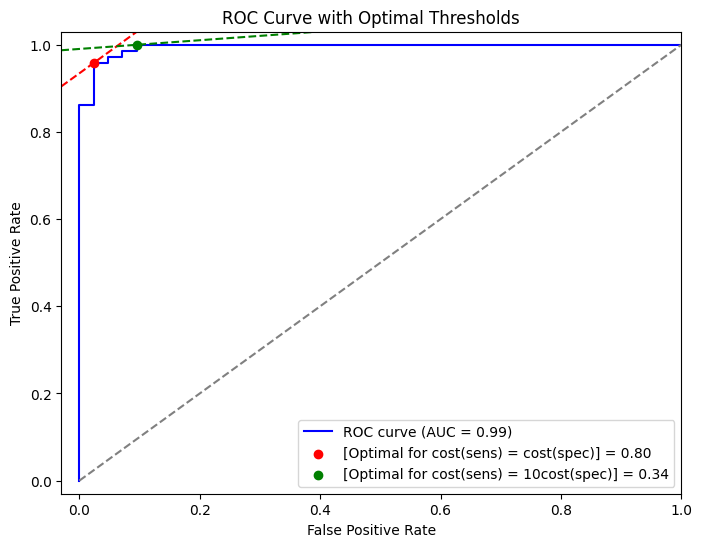

114


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from matplotlib.lines import Line2D

# Load the dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into 60% training, 20% validation, and 20% test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Train Logistic Regression model
model = LogisticRegression(max_iter=10000, random_state=42)
model.fit(X_train, y_train)

# Predict probabilities on validation set
y_val_prob = model.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

# Find the standard optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_fpr, optimal_tpr = fpr[optimal_idx], tpr[optimal_idx]

# Find the weighted optimal threshold when sensitivity is 10 times more important than specificity
costs = 10 * (1 - tpr) + fpr
optimal_idx_weighted = np.argmin(costs)
optimal_threshold_weighted = thresholds[optimal_idx_weighted]
optimal_fpr_weighted, optimal_tpr_weighted = fpr[optimal_idx_weighted], tpr[optimal_idx_weighted]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')

x_red = np.linspace(-0.03, 1, 100)
y_red = optimal_tpr - (optimal_fpr - x_red)

plt.plot(x_red, y_red, color='red', linestyle='--', label=f'[Optimal for cost(sens) = cost(spec)] = {optimal_threshold:.2f}')

x_green = np.linspace(-0.03, 1, 100)
y_green = optimal_tpr_weighted - (1/10) * (optimal_fpr_weighted - x_green)

plt.plot(x_green, y_green, color='green', linestyle='--', label=f'[Optimal for cost(sens) = 10cost(spec)] = {optimal_threshold_weighted:.2f}')

red_dot = plt.scatter(optimal_fpr, optimal_tpr, color='red', marker='o', zorder=5)

green_dot = plt.scatter(optimal_fpr_weighted, optimal_tpr_weighted, color='green', marker='o', zorder=5)

handles, labels = plt.gca().get_legend_handles_labels()

handles[1] = red_dot
handles[2] = green_dot

plt.xlim([-0.03, 1])
plt.ylim([-0.03, 1.03])

# Labels and show
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Thresholds')
plt.legend(handles=handles, labels=labels)
plt.show()

print(len(X_val))

## Testing model performance using various metrics

In [60]:
# Apply the optimal threshold to the test set
y_test_prob = model.predict_proba(X_test)[:, 1]

# Use the optimal threshold to make binary predictions
y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
sensitivity = recall  # Sensitivity is the same as recall
specificity = tn / (tn + fp)

# Print results
print(f"AUC Score: {roc_auc:.4f}")
print("\nNOT WEIGHTED")
print(f"Optimal Threshold (Youden’s J): {optimal_threshold:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")


# Apply the optimal threshold to the test set
y_test_prob = model.predict_proba(X_test)[:, 1]

# Use the optimal threshold to make binary predictions
y_test_pred = (y_test_prob >= optimal_threshold_weighted).astype(int)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
sensitivity = recall  # Sensitivity is the same as recall
specificity = tn / (tn + fp)

# Print results
print("\nWEIGHTED")
print(f"Optimal Threshold (Weighted for Sensitivity): {optimal_threshold_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"F1-Score: {f1:.4f} (I think it's not the best metric if we weight sens,spec)")
print(f"Specificity: {specificity:.4f}")

AUC Score: 0.9947

NOT WEIGHTED
Optimal Threshold (Youden’s J): 0.8019
Accuracy: 0.9649
Precision: 0.9855
Recall (Sensitivity): 0.9577
F1-Score: 0.9714
Specificity: 0.9767

WEIGHTED
Optimal Threshold (Weighted for Sensitivity): 0.3430
Accuracy: 0.9386
Precision: 0.9103
Recall (Sensitivity): 1.0000
F1-Score: 0.9530 (I think it's not the best metric if we weight sens,spec)
Specificity: 0.8372


## Answers

**Would a threshold different that 0.5 yield better results?**
- in general, yes. In our example the optimal threshold for maximizing TPR - FPR is 0.8. However, it's way more harmful to tell someone they don't have a breast cancer if they do rather than saying they do have it if then don't. Hence in our example we might value sensitivity more than specificity. Treating it as 10 times more important yields the optimal threshold of 0.34 as shown in the plot

**Is higher specificity more valuable than higher sensitivity in certain contexts? Or maybe the other way around?**
- yes. In our example sensitivity is more important than specificity. But for example in fraud detection it would be the other way around, since we really want to avoid falsly accusing someone of fraud

**Does the best threshold depend on the task?**
- answers in questions above strongly indicate that yes, it does

**How does a ROC curve help in this process?**
- it visualizes important sensitivity and specificity for different thresholds in a way so that it's easy to see which thresholds are optimal (given that we know how much should we value sensitivity vs specificity)

**How do you select the optimal threshold using the ROC curve?**
- it's visualised in the plot above. If you assign weights $w:1$ for sensitivity:specificity, you want to look for the biggest $k$ s.t. there exist $(x,y) \in ROC$ s.t. $wy-x = k$. The threshold corresponding to that point is the optimal threshold


**What is the AUC metric and how is it useful?**
- AUC is the area under the ROC curve. The point is that you can use methods other than Logistic Regression to try to predict to which class of a dataset a point belongs, for example Random Forest. The bigger AUC for a given method, the better the more suited the method is for that specifit dataset